In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

# Preprocessing and model selection
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# <b>CALIFORNIA HOUSE PRICE PREDICTION</b>
- by Abdurrahman Saleh Adijaya
- for Purwadhika's Data Science and Machine Learning Bootcamp: Capstone Project 3
- revision 1: 05-29-2023

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#0080FF'>PROBLEM STATEMENT</span></b></p></div>

For this project, we will position ourself as a property company. As a property company, our goal is to maximize profit while maintaining high customer satisfaction for both buyers and sellers. One approach is by developing a model that predicts an optimal house price given certain factors such as location, house age, etc. This ensures profitable returns and customer satisfaction, a win-win scenario.

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#0080FF'>LIMITATION</span></b></p></div>

- The California housing dataset contains housing attributes from the 1990 California census. Hence, it might not accurately predict the current housing prices.
- Housing property value can be affected by numerous factors (location, size, condition, time). We will limit our consideration to factors provided in the California housing dataset.
- Housing market volatility and external economic factors like interest rates and inflation complicate price prediction over time. This project does not account for these additional factors.
- Feature engineering will only be based on the dataset's given features.

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#0080FF'>GOALS</span></b></p></div>

Create a model to predict the `median_house_value`, our **target variable**, using provided dataset features.<br>
Below are some of the steps taken in this project to create the model:
- Address missing data with a basic unsupervised learning data imputation.
- Analyze all features related to the target variable, and create new features by feature engineering.
- Identify outliers in the dataset.

<div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#0080FF'>METRIC EVALUATION</span></b></p></div>

The model's performance will be evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).

- <b>MSE</b>: Measures the average squared differences between actual and predicted values. A lower value indicates a better fit.
- <b>MAE</b>: Evaluates the average absolute differences between actual and predicted values. As with MSE, a lower value signifies fewer errors.
- <b>MAPE</b>: Calculates the mean absolute percent difference between actual and predicted values. This relative measure of error allows for easy comparison across datasets or units. A lower value indicates more accurate predictions.

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>2 |</span></b> <b>DATA PREPARATION</b></div>


## <b><span style='color:#0080FF'> 2.1 |</span> Loading Dataset </b>

df.info(),describe(),head() are probably one of the first things we might want to inspect having a pandas dataframe; showing feature names, limits/stats and and a few first columns respectively, to get a some initial impression of the data

In [48]:
# Load dataset
df = pd.read_csv('data_california_house.csv')

In [49]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


From df.info() we can see there are <b>14448 rows</b> and <b>10 columns</b> of data.
- Only `ocean_proximity` column is categorical data, the others are numerical.
- Only `total_bedrooms` column that has missing data.

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| longitude | Float | Longitude coordinates, a measure of how far west a house is; a higher value is farther west |
| latitude | Float | Latitude coordinates, a measure of how far north a house is; a higher value is farther north |
| housing_median_age | Float | Median age of a house within a block; a lower number is a newer building |
| total_rooms | Float | Total number of rooms within a block|
| total_bedrooms | Float | Total number of bedrooms within a block |
| population | Float | Total number of people residing within a block |
| households | Float | Total number of households, a group of people residing within a home unit, for a block |
| median_income | Float | Median income for households within a block of houses (measured in tens of thousands of US Dollars) |
| ocean_proximity | Object | Location of the house with relation to ocean/sea |
| median_house_value | Float | Median house value for households within a block (measured in US Dollars) |

In [50]:
# Check for columns with missing data
missing_values = df.isnull().sum()
print(missing_values)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64


In [51]:
# Check for duplicated rows
print('Number of duplicated rows = ', df.duplicated().sum())

Number of duplicated rows =  0


## <b><span style='color:#0080FF'> 2.2 |</span> Data Imputation </b>
- We can note that we have a number of features with some missing data, but not too many instances overall (137/14448);
- Lets try an `Unsupervised Learning (UL)` approach based on the `kNN` model, we can use the function below and pass a dataframe to generated an imputed dataframe

In [52]:
def impute_knn(df, n_neighbors=5):
    ''' 
    Impute missing values using KNN imputation.
    
    Parameters:
    df : pandas DataFrame
    n_neighbors : int, optional (default = 5)
        Number of neighboring samples to use for KNN imputation.

    Returns:
    pandas DataFrame
        DataFrame where missing values have been imputed.
    '''
    # Separate dataframe into numerical and categorical
    df_num = df.select_dtypes(include=[np.number])
    df_cat = df.select_dtypes(exclude=[np.number])

    # Define scaler and imputer outside of pipeline for inverse_transform
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Apply scaler, imputer and inverse_transform
    df_num[df_num.columns] = scaler.inverse_transform(
                                imputer.fit_transform(
                                    scaler.fit_transform(df_num)
                                )
                             )

    # Concatenate numerical and categorical data
    return pd.concat([df_num, df_cat], axis=1)


In [53]:
df2 = impute_knn(df)

In [54]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14448 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   median_house_value  14448 non-null  float64
 9   ocean_proximity     14448 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>3 |</span></b> <b>EXPLORATORY DATA ANALYSIS</b></div>

## <b><span style='color:#0080FF'> 3.1 |</span> Univariate Histograms </b>

We will examine the data distribution using <b>univariate analysis</b> (analysis of a single variable). Factors to consider when observing histograms:

- Data distribution (some models perform better with less skewed distributions)
- Outliers (noisy data can impact model performance)
- Odd data patterns (abnormalities can affect model performance)
- Axis Scale (feature scale values can impact a model's performance)

In [9]:
def plot_histograms(df, bins=60, figsize=(15,9), color='skyblue'):
    """
    Plots histograms of all numerical columns in a DataFrame.

    Parameters:
    df : pandas DataFrame
        Data to plot.
    bins : int, optional (default = 60)
        Number of bins to use in histogram.
    figsize : tuple, optional (default = (15,9))
        Size of the figure.
    color : str, optional (default = 'skyblue')
        Color of the histograms.

    Returns:
    None
    """
    df.hist(bins=bins, figsize=figsize, color=color)
    plt.show()

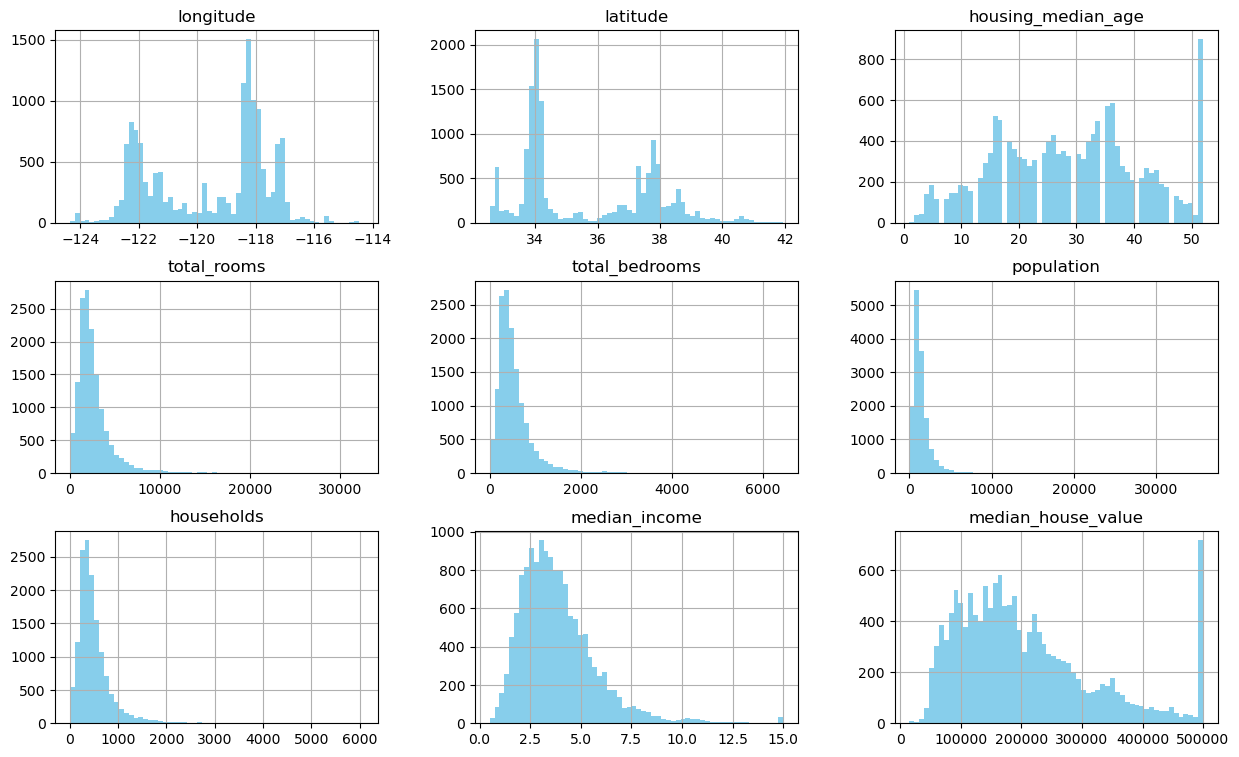

In [10]:
plot_histograms(df2)

**<span style='color:#0080FF'>Odd Patterns & Outliers</span>**<br>
A few noticeable inconsistencies are present in our data, which may be a result of the data sampling process. Particularly in the `housing_median_age` and `median_house_value` features.
- The `housing_median_age` feature exhibits several gradual local peaks, with a pronounced odd peak at the maximum value. This may point to data discontinuity.
- The `median_house_value` feature shows a peculiar peak around 500k, which might be an outlier.

**<span style='color:#0080FF'>Less Noticeable Outliers</span>**<br>
There are several skewed data distributions present in the dataset. Six features display such distributions: `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, and `median_house_value`.
- The range of the x-axis for some of these features (e.g., `population`) is broad, indicating potential outliers.
- The `population`, `total_bedrooms`, and `total_rooms` features have similar distributions, skewed towards smaller values. These features are somewhat interconnected.

## <b><span style='color:#0080FF'> 3.2 |</span> Bivariate Correlation Matrix </b>
A Bivariate Correlation Matrix provides a quick overview of the relationships between pairs of features in the dataset. It only contains information about the linear similarity between two features.<br>

<b>Key Observations</b>
- High or low correlation between features might suggest redundancy, prompting consideration to drop such features.
- Low linear correlation values could indicate nonlinearity in the dataset.
- Multiple features with high correlation may imply that they represent similar concepts.

In [11]:
def correlation_matrix(df, figsize=(7,7), cbar=True):
    """
    Plot correlation matrix of DataFrame features.

    Parameters:
    df : pandas DataFrame
        DataFrame to calculate correlations on.
    figsize : tuple of int, optional (default = (7,7))
        Figure size.
    cbar : bool, optional (default = True)
        If True, display a colorbar.

    Returns:
    None
    """
    plt.rcParams.update({'font.size': 10})
    corr_mat = df.corr().round(2)

    plt.figure(figsize=figsize)
    
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    
    sns.heatmap(corr_mat, mask=mask, vmin=-1, vmax=1, center=0,
                cmap='cool', square=True, linewidths=2,
                annot=True, cbar=cbar)

    plt.title('Correlation Heatmap')
    plt.show()

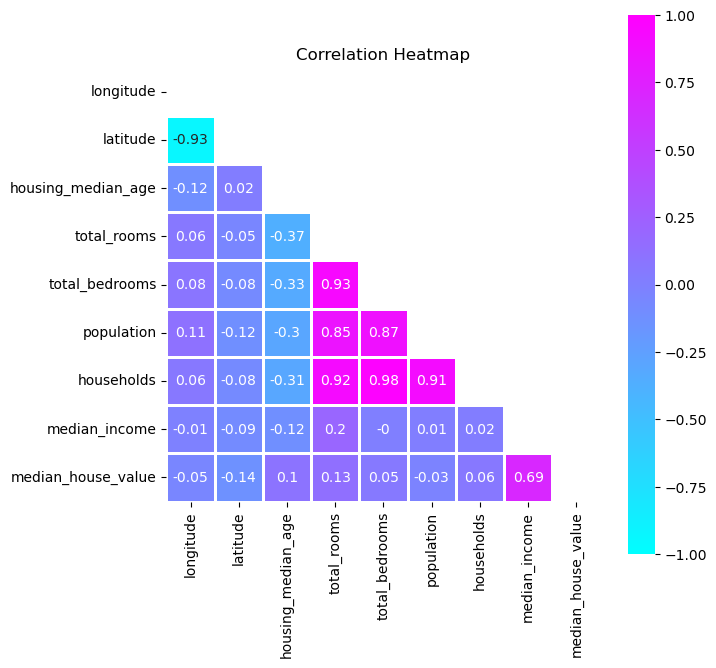

In [12]:
correlation_matrix(df2)

- Our target variable, `median_house_value`, shows moderate correlation with all but one feature, `median_income`, which appears to be significantly correlated. Other features with slightly higher correlation include `total_rooms` and `latitude`.
- Some features, such as `population`, have very low correlation with the target variable. Instead of discarding these features, we recognize they may indicate a wide data spread, suggesting nonlinearity. We will rely on algorithms to determine the importance of features in the feature selection process later on.

## <b><span style='color:#0080FF'> 3.3 |</span> Geospatial Multivariate Data </b>
Multivariate visualization, where data is colored or 'hued' to represent an additional variable, can offer deeper insights than bivariate visualization, particularly when data overlap is minimal. Geographic plotting is one such form of visualization, allowing us to discern how geography influences various features. For geographic data, tools like geopandas, folium, and Plotly can be beneficial.

In [13]:
def plot_geospatial(df, lst, figsize=(21,6), cmap='cool', point_size=3, alpha=1.0):
    """
    Plot geographical scatter plot for given list of features in California.

    Parameters:
    df : pandas DataFrame
        Data to plot.
    lst : list of str
        List of features to plot.
    figsize : tuple, optional (default = (21,6))
        Size of the figure.
    cmap : str, optional (default = 'plasma')
        Color map to use for the points.
    point_size : int, optional (default = 3)
        Size of the points in the scatter plot.
    alpha : float, optional (default = 1.0)
        Transparency of the points in the scatter plot.

    Returns:
    None
    """
    # load California from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)

    # Create a geopandas geometry feature
    gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df.longitude, df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944)

    fig,ax = plt.subplots(1, len(lst) if len(lst) > 1 else 1, figsize=figsize, subplot_kw={'projection': proj})
    ax = ax if isinstance(ax, np.ndarray) else [ax]

    for axi, var in zip(ax, lst):
        tgdf = gdf.sort_values(by=var, ascending=True) 
        gplt.polyplot(cali, projection=proj, ax=axi)
        gplt.pointplot(tgdf, ax=axi, hue=var, cmap=cmap, legend=True, alpha=alpha, s=point_size)
        axi.set_title(var)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)
    plt.show()

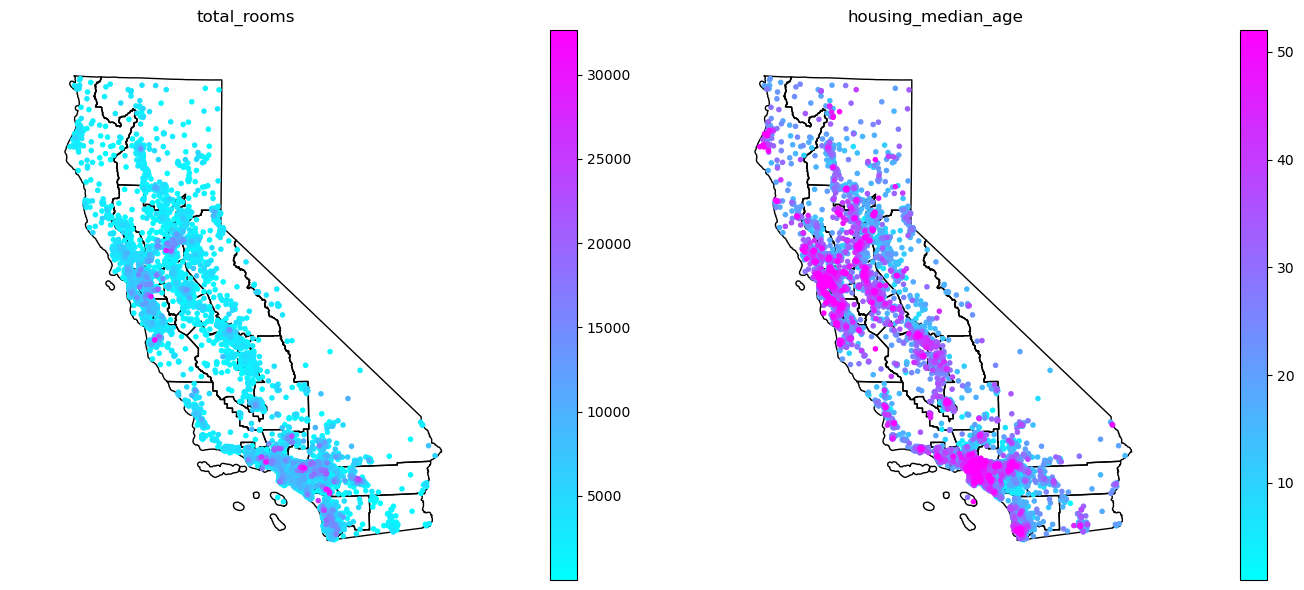

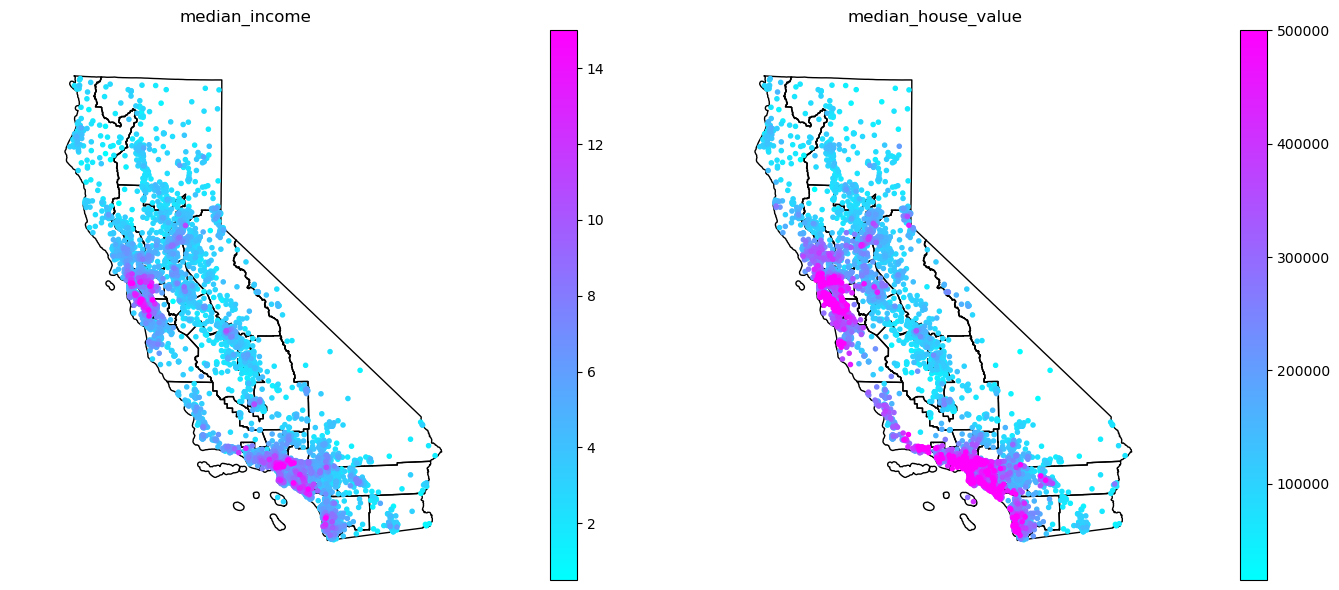

In [14]:
# Call function that plots two geopandas plots
# Only plot top 3 features and target variable
plot_geospatial(df2,['total_rooms','housing_median_age'])
plot_geospatial(df2,['median_income','median_house_value'])

Observing the geographic distribution of our target variable, `median_house_value`, reveals noticeable patterns:

- Both `geography(location)` and `median_income` show clear relationships with the target variable. Generally, the closer properties are to the two main clusters, the higher the value, suggesting these features will likely be important.
- `housing_median_age` appears strongly correlated with the target variable in many regions, but less so in some inland areas. This suggests a potential non-linear relationship. Despite this, two primary clusters exhibit some linearity.
- Interpreting `total_rooms` is a bit more complex due to outliers (barely visible on the univariate histogram). These outliers skew the visualization, making it harder to discern a relationship as most values are clustered below 10k. However, the correlation value suggests a relationship exists.

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>4 |</span></b> <b>FEATURE ENGINEERING</b></div>

Feature engineering, the process of creating and modifying a feature matrix, plays a crucial role in modeling. It's a cyclical process aimed at feeding the model the most relevant data for predicting the target variable, ideally with minimal overlap.<br>

Highly correlated features may teach a model similar concepts repetitively. One approach to handle such redundancy might involve combining these features and dropping others.

#### **<span style='color:#0080FF'>Possible Approach:</span>**

Despite the limited number of features in our dataset, we observed a few that are quite similar. Here are some strategies we can employ:
- Feature Combination: We can create a simple combination from the similar features. During the feature selection stage, we will filter through all features to retain only those of higher importance.
- Geographic Combination: Given the relationship we observed in the multivariate data, which changes along a diagonal axis (moving closer to or farther from the ocean), we can create a feature combining both coordinates.

In [55]:
# Geographic combination
df2['diag_coord'] = (df2['longitude'] + df2['latitude'])

# Feature combination
df2['bed_per_room'] = df2['total_bedrooms']/df2['total_rooms'] # Bed per room feature
df2['room_per_hh'] = df2['total_rooms']/df2['households'] # Room per household feature
df2['pop_per_hh'] = df2['population']/df2['households'] # Population per household feature

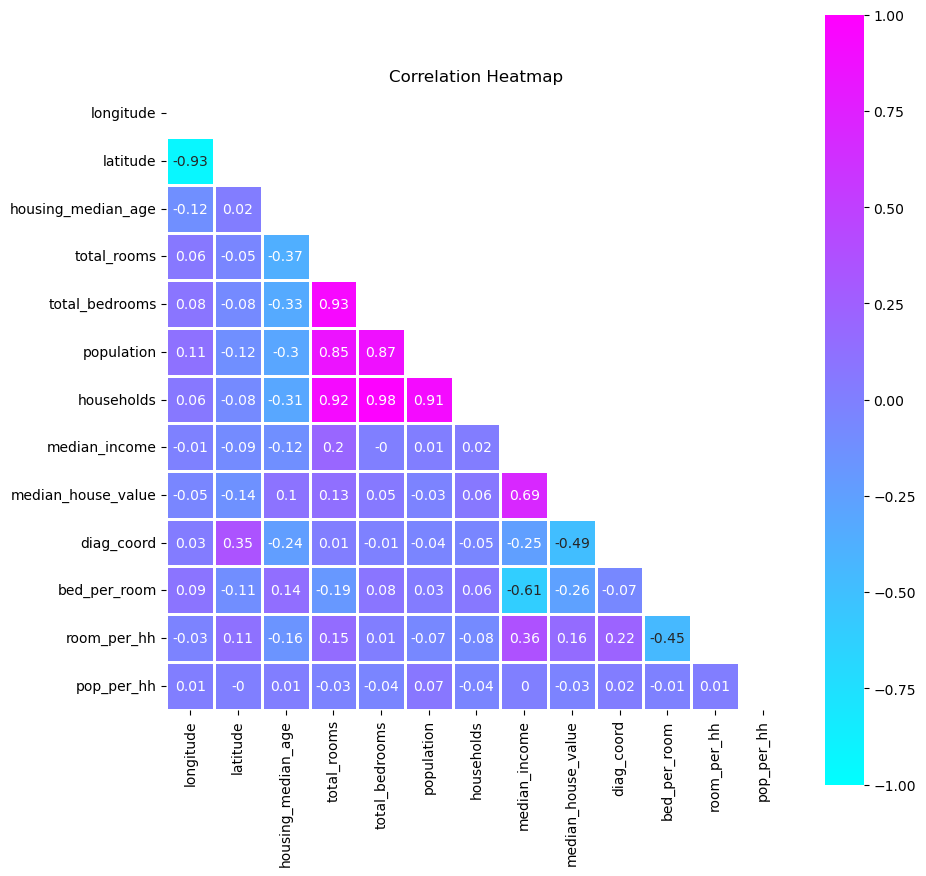

In [56]:
correlation_matrix(df2, figsize=(10,10))

From the correlation matrix we can see that all new features except `pop_per_hh` have more significant correlation to our target variable than the existing features.

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>5 |</span></b> <b>OUTLIER HANDLING</b></div>

Once we've performed feature engineering, including creating new features, we'll turn our attention to handling outliers.<br>
We'll use the process_outliers function, which performs the following steps:
1. <b>Calculate Interquartile Range (IQR)</b>: For each column, compute the IQR, which is the range between the first quartile (25th percentile) and the third quartile (75th percentile).
2. <b>Establish Lower and Upper Limits</b>: Determine these limits for each column. Any data point outside these limits is considered an outlier.
3. <b>Identify Outliers</b>: Count the total data points in each column that fall below the lower limit or above the upper limit.
4. <b>Remove Outliers</b>: Eliminate the data points identified as outliers from each column.

In [57]:
def process_outliers(df):
    column_list = ['median_house_value', 'median_income', 'housing_median_age',
                   'total_bedrooms', 'total_rooms', 'population', 'households',
                   'pop_per_hh', 'bed_per_room', 'room_per_hh']

    bounds_dict = {}
    for col in column_list:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Find IQR and calculate bounds
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_limit = q1 - 1.5*iqr
            upper_limit = q3 + 1.5*iqr

            # Store bounds for each column in a dictionary
            bounds_dict[col] = (lower_limit, upper_limit)

            # Count outliers
            under_q1 = df[df[col] < lower_limit][col].count()
            over_q3 = df[df[col] > upper_limit][col].count()
            print(f"\n> Number of {col} < Lower Limit ({lower_limit}) = {under_q1} | Number of {col} > Upper Limit ({upper_limit}) = {over_q3}")

        else:
            print(f'\nColumn: {col} is not numeric, skipping.')
            
    # Remove outliers
    for col in column_list:
        if col in bounds_dict:
            lower_limit, upper_limit = bounds_dict[col]
            df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]
    
    return df

In [58]:
df2 = process_outliers(df2)


> Number of median_house_value < Lower Limit (-96850.0) = 0 | Number of median_house_value > Upper Limit (480350.0) = 757

> Number of median_income < Lower Limit (-0.6776500000000012) = 0 | Number of median_income > Upper Limit (7.984350000000001) = 482

> Number of housing_median_age < Lower Limit (-10.5) = 0 | Number of housing_median_age > Upper Limit (65.5) = 0

> Number of total_bedrooms < Lower Limit (-233.0) = 0 | Number of total_bedrooms > Upper Limit (1175.0) = 887

> Number of total_rooms < Lower Limit (-1094.5) = 0 | Number of total_rooms > Upper Limit (5693.5) = 900

> Number of population < Lower Limit (-626.0) = 0 | Number of population > Upper Limit (3134.0) = 827

> Number of households < Lower Limit (-208.5) = 0 | Number of households > Upper Limit (1091.5) = 842

> Number of pop_per_hh < Lower Limit (1.1475032860584282) = 3 | Number of pop_per_hh > Upper Limit (4.560210696794743) = 491

> Number of bed_per_room < Lower Limit (0.08006352131324994) = 0 | Number of bed

In [59]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11442 entries, 1 to 14447
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           11442 non-null  float64
 1   latitude            11442 non-null  float64
 2   housing_median_age  11442 non-null  float64
 3   total_rooms         11442 non-null  float64
 4   total_bedrooms      11442 non-null  float64
 5   population          11442 non-null  float64
 6   households          11442 non-null  float64
 7   median_income       11442 non-null  float64
 8   median_house_value  11442 non-null  float64
 9   ocean_proximity     11442 non-null  object 
 10  diag_coord          11442 non-null  float64
 11  bed_per_room        11442 non-null  float64
 12  room_per_hh         11442 non-null  float64
 13  pop_per_hh          11442 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.3+ MB


After running `process_outliers` function we are left with <b>11442</b> data from <b>14448</b> original data, a total of <b>3006</b> data are removed.

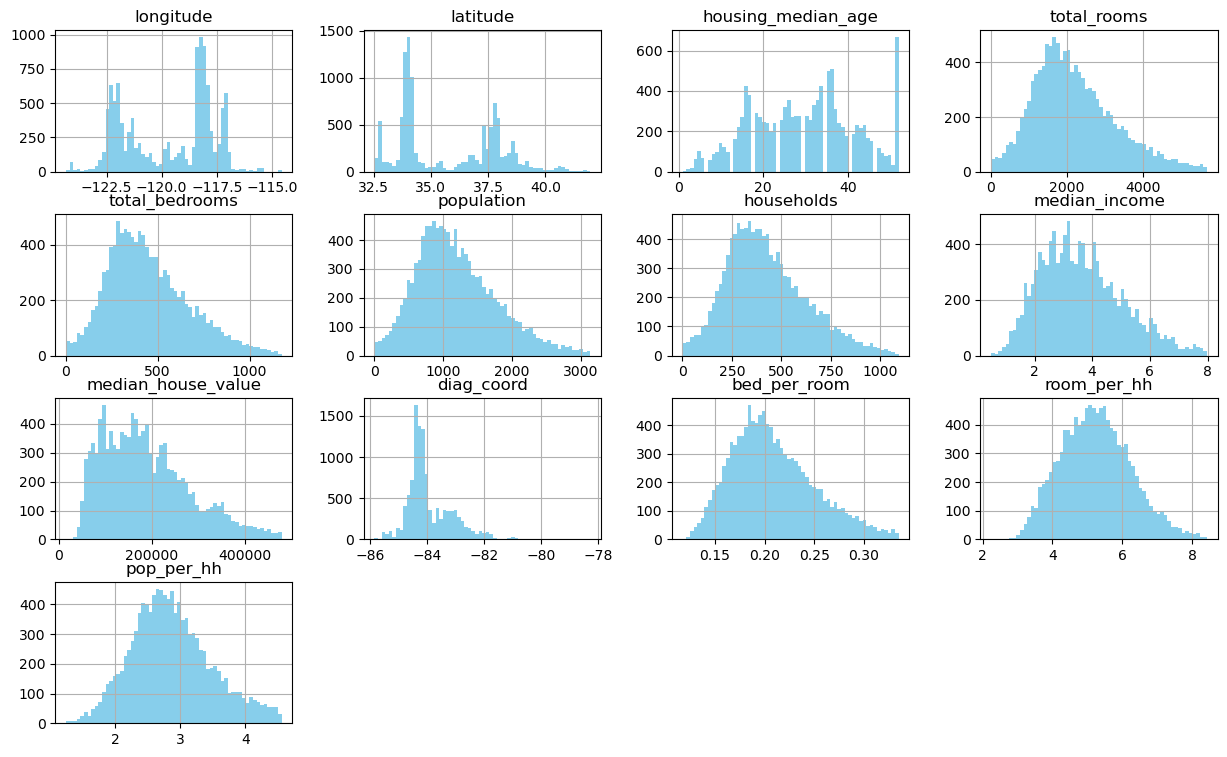

In [20]:
plot_histograms(df2)

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>6 |</span></b> <b>MODELLING</b></div>

## <b><span style='color:#0080FF'> 6.1 |</span> Encoding </b>

In order to use all features, categorical feature (`ocean_proximity`) need to be converted into numerical.

In [60]:
# Instantiate the encoder
encoder = OneHotEncoder()

# Fit and transform the data
ocean_proximity_encoded = encoder.fit_transform(df2[['ocean_proximity']]).toarray()

# Convert the encoded data into a DataFrame
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=encoder.get_feature_names(['ocean_proximity']))

# Drop the original 'ocean_proximity' column
df2 = df2.drop('ocean_proximity', axis=1).reset_index(drop=True)

# Concatenate the original DataFrame and the one-hot encoded DataFrame
df2 = pd.concat([df2, ocean_proximity_df], axis=1)

In [61]:
# Rename the columns
column_names = {
    'ocean_proximity_<1H OCEAN': 'proximity_1H_OCEAN',
    'ocean_proximity_INLAND': 'proximity_INLAND',
    'ocean_proximity_ISLAND': 'proximity_ISLAND',
    'ocean_proximity_NEAR BAY': 'proximity_NEAR_BAY',
    'ocean_proximity_NEAR OCEAN': 'proximity_NEAR_OCEAN'
}

df2 = df2.rename(columns=column_names)

## <b><span style='color:#0080FF'> 6.2 |</span> Feature Selection </b>

In this section, we will execute the following steps:
1. <b>Split the Data</b>: Divide the dataset into a training set and a testing set. We split it into 70% train and 30% test data.
2. <b>Scale the Data</b>: Apply a scaling technique, Standard Scaling, to both the training and testing data. This step ensures that all features have a similar scale, which can improve the performance of some machine learning models.
3. <b>Identify Important Features</b>: Use algorithms, such as Linear Regression or Random Forest, to identify 9 number of features with high importance. We select 9 because previously we already tested the model with 5 and 7 features and resulted in 81% r2_score, we want to increase this by increasing features.
4. <b>Filter Data</b>: Modify the training and testing data sets to include only those features identified as important in the previous step. This focuses the model on the most relevant information and can improve its predictive performance.

In [81]:
# Define the features and the target
X = df2.drop('median_house_value', axis=1)
y = df2['median_house_value']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [82]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back into DataFrames
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [83]:
def select_features(estimator, n_features, X_train, y_train):
    selector = RFE(estimator=estimator, n_features_to_select=n_features)
    selector.fit(X_train, y_train)
    return X_train.columns[selector.support_]

models = {
    "Linear Regression": LinearRegression(), 
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge()
}

selected_features = {}

for model_name, model in models.items():
    selected_features[model_name] = select_features(model, 9, X_train, y_train)
    print(f"Selected features ({model_name}): {selected_features[model_name]}")

Selected features (Linear Regression): Index(['longitude', 'latitude', 'median_income', 'diag_coord',
       'proximity_1H_OCEAN', 'proximity_INLAND', 'proximity_ISLAND',
       'proximity_NEAR_BAY', 'proximity_NEAR_OCEAN'],
      dtype='object')
Selected features (Random Forest Regressor): Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'median_income', 'diag_coord', 'bed_per_room', 'room_per_hh',
       'pop_per_hh'],
      dtype='object')
Selected features (XGBoost): Index(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'diag_coord', 'room_per_hh', 'pop_per_hh', 'proximity_1H_OCEAN',
       'proximity_NEAR_BAY'],
      dtype='object')
Selected features (Lasso): Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'diag_coord', 'bed_per_room', 'room_per_hh',
       'pop_per_hh'],
      dtype='object')
Selected features (Ridge): Index(['housing_median_age', 'population', 'households', 'median_in

From the result we see that `longitude`, `latitude`, `housing_median_age`, `median_income`, `diag_coord`, `room_per_hh`, `pop_per_hh`, `proximity_1H_OCEAN`, and `proximity_NEAR_BAY` frequently appear. Thus we will select those 9 and drop the rest 7 features.

In [84]:
selected_features = ['longitude', 'latitude', 'housing_median_age', 'median_income',
       'diag_coord', 'room_per_hh', 'pop_per_hh', 'proximity_1H_OCEAN',
       'proximity_NEAR_BAY']

# Create new dataframes with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

## <b><span style='color:#0080FF'> 6.3 |</span> Model Selection </b>

In this section, we will search for the best model we can use between Linear Regression, RandomForest Regressor, XGBoost Regressor, Lasso, and Ridge. We will use Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and their standard deviations as the evaluation metrics.

In [85]:
def evaluate_model(estimator, X, y, cv):
    scores = {}
    scoring_metrics = {
        "MSE": 'neg_mean_squared_error', 
        "MAE": 'neg_mean_absolute_error', 
        "MAPE": 'neg_mean_absolute_percentage_error'
    }

    for metric_name, scoring in scoring_metrics.items():
        model_cv_score = cross_val_score(estimator, X, y, cv=cv, scoring=scoring, error_score='raise')
        scores[f'Mean_{metric_name}'] = -1 * model_cv_score.mean()
        scores[f'Std_{metric_name}'] = model_cv_score.std()

    return scores

# Search best algorithm based on each metrics
models = {
    "Linear Regression": TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp),
    "RandomForest Regressor": TransformedTargetRegressor(RandomForestRegressor(random_state=42), func=np.log, inverse_func=np.exp),
    "XGBoost Regressor": TransformedTargetRegressor(XGBRegressor(random_state=42), func=np.log, inverse_func=np.exp),
    "Lasso": TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp),
    "Ridge": TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp)
}

crossval = KFold(n_splits=5, shuffle=True, random_state=42)

model_scores = []
for model_name, model in models.items():
    scores = evaluate_model(model, X_train_selected, y_train, crossval)
    scores['Model'] = model_name
    model_scores.append(scores)

# Evaluate result from 5 algorithm candidates
result_df = pd.DataFrame(model_scores)
display(result_df)

,Mean_MSE,Std_MSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Model
0,3.351277e+09,1.038111e+08,41697.042966,621.457585,0.240654,0.002537,Linear Regression
1,1.831130e+09,9.668396e+07,28388.009647,378.617581,0.158361,0.001858,RandomForest Regressor
2,1.651470e+09,6.347085e+07,27092.709152,460.801374,0.150333,0.002279,XGBoost Regressor
3,9.530943e+09,4.685428e+08,75811.318633,1444.952645,0.488490,0.008881,Lasso
4,3.350873e+09,1.038873e+08,41693.154976,631.966537,0.240647,0.002554,Ridge


From the result, we can conclude that the XGBoost Regressor and RandomForest Regressor models perform the best based on all three metrics - MSE, MAE, and MAPE. This means that these models, on average, predict values that are closest to the actual values.

1. `XGBoost Regressor` has the lowest Mean_MSE, which means it has the lowest average squared difference between the estimated values and the actual value. It also has the lowest Mean_MAE, implying that it has the smallest average absolute difference between the estimated and actual value. Lastly, it has the lowest Mean_MAPE, suggesting that it has the smallest average difference between the estimated and actual value as a percentage of the actual value.

2. `RandomForest Regressor` comes in a close second in all these metrics. Its Mean_MSE, Mean_MAE, and Mean_MAPE values are slightly higher than those of the XGBoost Regressor, but it's still significantly better than the other models (Linear Regression, Lasso, Ridge).

In terms of the standard deviations of these metrics, both models show relatively similar values, suggesting they have comparable variability in their performance across different cross-validation folds.

Based on these results, both the XGBoost and RandomForest models are quite effective, and we will compare them both in the next step.

In [86]:
np.random.seed(0)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape

# Define pipeline with just a placeholder for the model
pipeline = Pipeline([
    ('model', None)  # We will set the model in the loop
])

models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGB': XGBRegressor(random_state=42)
}

score_before_tuning = []

for model_name, model in models.items():
    try:
        pipeline.set_params(model=model)
        pipeline.fit(X_train_selected, y_train)
        y_pred = pipeline.predict(X_test_selected)
        mse, mae, mape = compute_metrics(y_test, y_pred)

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train_selected, y_train, cv=5)
        mean_cv_score = np.mean(cv_scores)

        score_before_tuning.append({
            'Model': model_name,
            'MSE': mse,
            'MAE': mae,
            'MAPE': mape,
            'Mean CV Score': mean_cv_score
        })
    
    except Exception as e:
        print(f"Failed to fit and predict with model {model_name}: {str(e)}")

score_before_tuning_df = pd.DataFrame(score_before_tuning)
score_before_tuning_df

,Model,MSE,MAE,MAPE,Mean CV Score
0,RandomForest,1.739774e+09,27911.138579,0.164361,0.792598
1,XGB,1.567264e+09,26997.065471,0.158097,0.809934


From the comparison result above, the `XGBoost` model performs better than the `RandomForest` model according to all metrics:

1. MSE: The XGB model has a `lower MSE` than the RandomForest model. This means that, on average, the squared difference between the estimated values and the actual values is lower for XGB, indicating better performance.
2. MAE: The XGB model has a `lower MAE` than the RandomForest model. This means that the average absolute difference between the estimated values and the actual values is smaller for XGB, indicating better performance.
3. MAPE: The XGB model has a `lower MAPE` than the RandomForest model. This means that, on average, the absolute percentage difference between the estimated values and the actual values is smaller for XGB, indicating better performance.
4. Mean CV Score: The XGB model has a `higher Mean CV Score` than the RandomForest model. This indicates that the XGB model's performance is more consistent across different cross-validation folds, suggesting that it's more robust and less likely to be overfitting to the training data.

We will then continue to hyperparameter tuning by using `XGBoost` as final model.

## <b><span style='color:#0080FF'> 6.4 |</span> Hyperparameter Tuning </b>

In [68]:
# Define the parameters grid
parameters = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize an XGBoost regressor
xgb = XGBRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=parameters, 
    n_iter=100,  # increased from the default of 10
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_selected, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   2.2s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=500, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.25

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6,

In [69]:
# Save best parameter to file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(random_search.best_params_, f)

# Save whole model to file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

In [87]:
# Load saved parameters:
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

# Instantiate model with the best parameters
final_model = XGBRegressor(**best_params)

# Fit the model to the training data
final_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = final_model.predict(X_test_selected)

# Compute metrics
mse, mae, mape = compute_metrics(y_test, y_pred)

# Create a DataFrame to store the metrics
score_after_tuning_df = pd.DataFrame({
    'Model': ['XGB Tuned'],
    'MSE': [mse],
    'MAE': [mae],
    'MAPE': [mape]
})

# Compute the mean CV score for the tuned XGBoost model
cv_score_tuned = cross_val_score(final_model, X_train_selected, y_train, cv=5).mean()

# Include the mean CV score in the 'score_after_tuning_df'
score_after_tuning_df['Mean CV Score'] = cv_score_tuned

In [88]:
# Concatenate the dataframes
final_scores_df = pd.concat([score_before_tuning_df, score_after_tuning_df], axis=0, ignore_index=True)
final_scores_df.drop(final_scores_df[final_scores_df['Model'] == 'RandomForest'].index, inplace=True)
display(final_scores_df)

,Model,MSE,MAE,MAPE,Mean CV Score
1,XGB,1.567264e+09,26997.065471,0.158097,0.809934
2,XGB Tuned,1.434720e+09,25419.998632,0.148058,0.828852


From the comparison, it can be observed that the XGBoost model's performance has improved after tuning:

1. MSE: The MSE has `decreased` in the tuned XGB model. This shows that the average squared difference between the actual and predicted values is lower after tuning, indicating an improvement in the model's accuracy.
2. MAE: The MAE has `decreased` in the tuned XGB model. This shows that the average absolute difference between the actual and predicted values is lower after tuning, further demonstrating an improvement in the model's accuracy.
3. MAPE: The MAPE has `decreased` in the tuned XGB model. This shows that the average absolute percentage difference between the actual and predicted values is lower after tuning, signifying an enhancement in the model's precision.
4. Mean CV Score: The Mean CV Score has `increased` in the tuned XGB model. This improvement indicates that the tuned model's performance is more consistent across different subsets of the data, suggesting it's less likely to overfit to the training data and more likely to perform well on unseen data.

In conclusion, the tuning process has resulted in `improvements` in all metrics, and the `tuned XGBoost model` will be used as the final model.

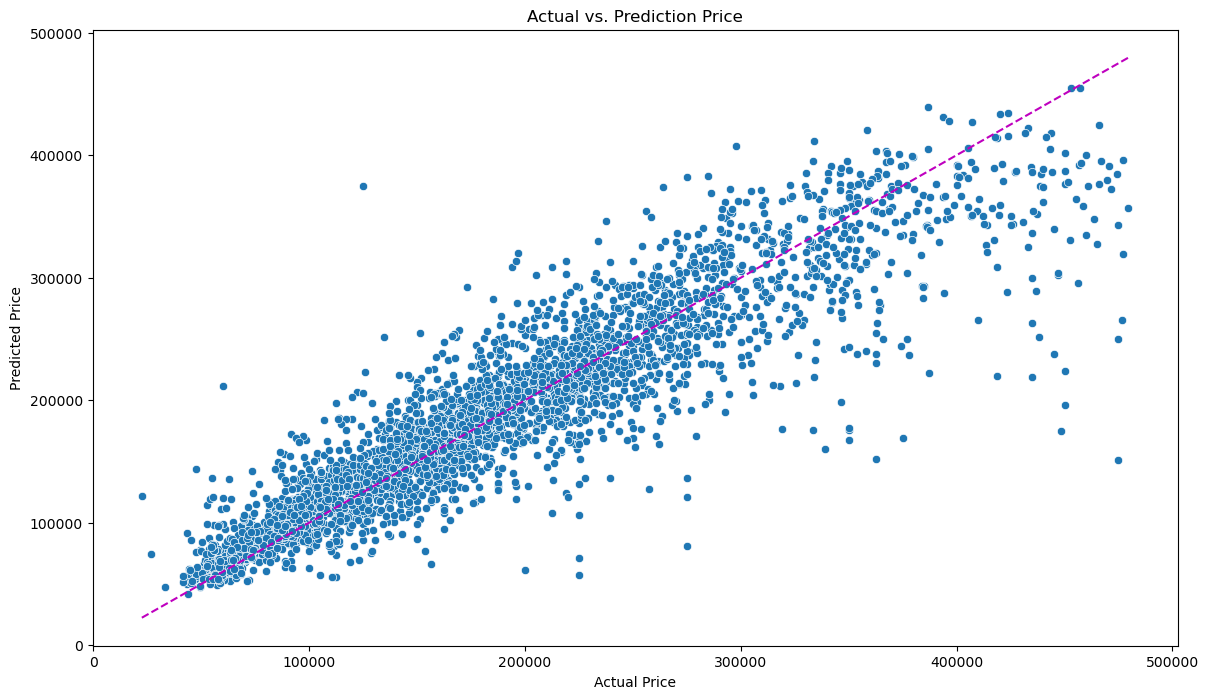

In [89]:
# Create Actual vs Prediction Price plot
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Prediction Price')
plt.show()

From the plot above, we can see it has a relative `linear` results until `400000` price. It means that the model will likely work well in lower price, preferably `<350000`.

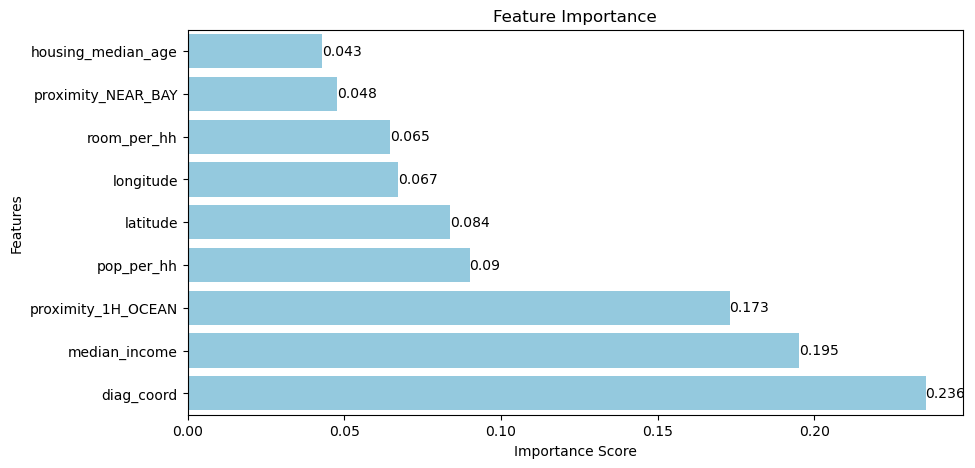

In [90]:
# Create Feature Importance plot
importance = pd.Series(data=final_model.feature_importances_, index=X_train_selected.columns)
importance_sorted = importance.sort_values()  # Sort values in ascending order

plt.figure(figsize=(10, 5))
barplot = sns.barplot(x=importance_sorted, y=importance_sorted.index, color='skyblue')

# Add labels to the graph
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')

# Adding the text labels inside the bars
for i in range(importance_sorted.shape[0]):
    barplot.text(x=importance_sorted[i], 
                 y=i, 
                 s=round(importance_sorted[i], 3),  # Show the value rounded to 3 decimal places
                 color='black', 
                 ha='left', 
                 va='center')
plt.show()

From the plot above we can see the most important features in final model using XGBoost is `diag_coord`, while `housing_median_age` is the least important. Our new features from previous feature engineering have important role in this model (`diag_coord`, `pop_per_hh`, and `room_per_hh`).

# <div style="padding: 30px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#0080FF"><b><span style='color:#FFFFFF'>7 |</span></b> <b>CONCLUSION</b></div>

From the modelling results, the three most impactful features for predicting the target variable `median_house_value` are:

1. `diag_coord`: Diagonal coordinates, a derived feature combining `longitude` and `latitude` values.
2. `median_income`: The median income for households within a block (measured in tens of thousands of US Dollars).
3. `proximity_1H_OCEAN`: This feature originates from `ocean_proximity` and was created after encoding.

The model's performance was assessed using MSE, MAE, MAPE, and Mean CV Score, with the final model yielding a `Mean CV Score` of `0.828852`. A higher Mean CV Score suggests the model consistently performs well across different data subsets, indicating it is not overfitting the training data. Hence, it is expected to deliver similar performance on unseen data, with an anticipated deviation of around `~15%` from the actual value, as suggested by the MAPE score. <br>

However, it's essential to note the model's limitations:

- It is anticipated to perform better for `median_house_value` < 350,000, based on the Actual vs Prediction plot.
- Only `9` out of the total `16` features are utilized (including engineered features).
- The model does not account for external factors like housing market volatility, interest rates, and inflation.

## <b><span style='color:#0080FF'> 7.1 |</span> Recommendation </b>

For future enhancements of the model, consider the following recommendations:

- `A/B Testing`: Implement A/B testing to gauge the model's effectiveness in terms of profit and customer satisfaction levels and compare it with manually predicted median_house_value by property agents.

- `Newer and More Data`: Acquiring more recent data will aid in predicting current prices since the dataset used is from the 1990 California census. Incorporating more details, such as house size and amenities (garage, pools, etc.), could improve the model's performance for `median_house_value` > 400,000.

- `Feature Engineering`: Advanced feature engineering could benefit the model. This could involve creating interaction terms between variables or integrating domain-specific knowledge into new features.

- `Further Hyperparameter Tuning`: Explore different hyperparameter values or consider tuning hyperparameters of various models. It could also be worthwhile to explore other types of models.

- `Ensemble Methods`: Utilize ensemble methods, like stacking or blending, to combine multiple model predictions and achieve superior performance.

- `Uncertainty Quantification`: It could be advantageous to predict not just the median house value but also provide an uncertainty or confidence interval estimate for that prediction. Some models can naturally provide such estimates, or bootstrapping techniques can be used to quantify uncertainty.